<a href="https://colab.research.google.com/github/fehimecapar/DeepLearning/blob/main/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 2 – MLP, Learning rate, Overfitting, and Hyper-parameters.

### <span style="color:red">Deadline Tuesday, June 3, 2025 at 11:59 p.m<span>

# IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to task02_[name].ipynb
- Only submit the ipynb file, no other file is required.
- The deadline is strict.
- Minimal requirement for passing: solving all code cells.

Implementation
- Do not change the cells which are marked as "Do not change", similarly write your solution to the marked cells. Do not create additional cells.

# Introduction

In this task you will implement an MLP model for virtual sensing using the flood dataset.
The objectives are:
- Implementing an MLP model via TensorFlow Functional API.
- Getting more familiar with model fitting and overfitting.
- Implementing early stopping.
- Exploring hyperparameters and their influence.
- Selecting model architecture.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

*   [Scikit-learn Tutorials](https://www.tensorflow.org/tutorials)
*   [TensorFlow Tutorials](https://scikit-learn.org/stable/tutorial/index.html)
*   [Matplotlib Tutorials](https://matplotlib.org/stable/tutorials/index.html)

## Imports

In [2]:
import numpy as np
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks, Input

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 24
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## System checks


In [3]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(gpus)
print(cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Choose your device for computation. CPU or one of your CUDA devices

In [4]:
tf.config.set_visible_devices(gpus, 'GPU')

# Subtask 2.1

## Backpropagation – Chain Rule

### Model
Let us assume an MLP with one hidden layer containing one neuron with `sigmoid` function ($S(x) = 1 / (1 + e^{-x})$) as the activation function. The input and the output dimensions are equal to one. The activation function for the input and output layers is `linear`.
The mapping $f: x \to \tilde{y}$ from the input $x$ to output $\tilde{y}$ can be written as:
\begin{equation}
\tilde{y} = f(x) = w_2 S(w_1 x)
\end{equation}
where $w_1$ and $w_2$ are the weights of the model. Note that we do not have bias for this example. Let us consider mean-squared error as the loss function. The loss $\ell$ can be obtained as:
\begin{equation}
\ell = (y - \tilde{y})^2 = (y - w_2 S(w_1 x))^2
\end{equation}
where $y$ denotes the reference label. Let's initialize the weights as $w_1 = 0.1$ and $w_2 = 0.1$.

### Data

Let's assume we have a data set containing three samples as: $x = [1.0, 2.0, 3.0]^{T}$ and $y = [1.0, 4.0, 9.0]^{T}$.

#### TODO
 - Perform gradient descent by hand with a learning rate of 0.1. Train the model for 1 epoch with the batch size of 1.
 - Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

<span style='color:red'>**Your answer:**</span>

...

#### TODO
- Define two functions that compute the gradients of the loss with respect to $w_1$ and $w_2$ using analytical differentiation and chain rule.
- Use the functions you defined and train the model again using gradient descent and the same learning rate.
- Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dL_dw2(x, y, w1, w2):
    z = w1 * x
    s = sigmoid(z)
    y_pred = w2 * s
    dL = -2 * (y - y_pred) * s
    return dL

def dL_dw1(x, y, w1, w2):
    z = w1 * x
    s = sigmoid(z)
    y_pred = w2 * s
    d_sigmoid = s * (1 - s)
    dL = -2 * (y - y_pred) * w2 * d_sigmoid * x
    return dL

# default weights
w1 = 0.1
w2 = 0.1
lr = 0.1

# Data
X = [1.0, 2.0, 3.0]
Y = [1.0, 4.0, 9.0]

for i in range(len(X)):
    x = X[i]
    y = Y[i]

    z = w1 * x
    s = sigmoid(z)
    y_pred = w2 * s

    #loss
    loss = (y - y_pred)**2

    grad_w1 = dL_dw1(x, y, w1, w2)
    grad_w2 = dL_dw2(x, y, w1, w2)

    # update weights
    w1 -= lr * grad_w1
    w2 -= lr * grad_w2

    # show
    print(f"value {i+1}")
    print(f"x = {x}, y = {y}")
    print(f"Prediction (ŷ) = {y_pred:.4f}")
    print(f"Loss = {loss:.4f}")
    print(f"Gradient w.r.t w1 = {grad_w1:.4f}, w2 = {grad_w2:.4f}")
    print(f"Updated w1 = {w1:.4f}, w2 = {w2:.4f}")
    print("-" * 40)


value 1
x = 1.0, y = 1.0
Prediction (ŷ) = 0.0525
Loss = 0.8978
Gradient w.r.t w1 = -0.0473, w2 = -0.9948
Updated w1 = 0.1047, w2 = 0.1995
----------------------------------------
value 2
x = 2.0, y = 4.0
Prediction (ŷ) = 0.1101
Loss = 15.1309
Gradient w.r.t w1 = -0.7675, w2 = -4.2957
Updated w1 = 0.1815, w2 = 0.6291
----------------------------------------
value 3
x = 3.0, y = 9.0
Prediction (ŷ) = 0.3981
Loss = 73.9928
Gradient w.r.t w1 = -7.5437, w2 = -10.8873
Updated w1 = 0.9358, w2 = 1.7178
----------------------------------------


#### TODO
- Use automatic differentiation (AD) (`tf.GradientTape`) to compute the gradients.
- Train the model again using the same learning rate, epoch, and batch size.
- Report the prediction $\tilde{y}$, loss, gradients, and the updated weights at every iteration.

In [6]:
# train data
x_data = tf.constant([1.0, 2.0, 3.0])
y_data = tf.constant([1.0, 4.0, 9.0])

# weihgts (as tf.Variable)
w1 = tf.Variable(0.1)
w2 = tf.Variable(0.1)

learning_rate = 0.1

for i in range(len(x_data)):
    x = x_data[i]
    y = y_data[i]

    with tf.GradientTape() as tape:
        z = w1 * x
        s = sigmoid(z)
        y_pred = w2 * s
        loss = (y - y_pred) ** 2

    # calculate gradients
    gradients = tape.gradient(loss, [w1, w2])
    grad_w1, grad_w2 = gradients

    # error catch
    if grad_w1 is None or grad_w2 is None:
        print(f"Gradyanlar None! Kontrol et: x={x}, y={y}, z={z}, s={s}, y_pred={y_pred}, loss={loss}")
        break

    # weights updating
    w1.assign_sub(learning_rate * grad_w1)
    w2.assign_sub(learning_rate * grad_w2)

    # show
    print(f"value {i+1}")
    print(f"x = {x.numpy():.1f}, y = {y.numpy():.1f}")
    print(f"Prediction (ỹ) = {y_pred.numpy():.4f}")
    print(f"Loss = {loss.numpy():.4f}")
    print(f"Gradient w.r.t w1 = {grad_w1.numpy():.4f}, w2 = {grad_w2.numpy():.4f}")
    print(f"Updated w1 = {w1.numpy():.4f}, w2 = {w2.numpy():.4f}")
    print("-" * 40)


Gradyanlar None! Kontrol et: x=1.0, y=1.0, z=0.10000000149011612, s=0.5249791741371155, y_pred=0.05249791964888573, loss=0.8977601528167725


# Subtask 2.2

In this task, we consider the data from **Margarethenklippe** as the input and train an MLP that gives the information about **Sennhuette** as the output. For each of the sensors, we have the water level, **W**, and the mass flow rate, **Q**, every 15 minutes.
## Pre-processing

#### TODO
 - Load the flood dataset (`Flood_Data.csv`) using *pandas* library.
 - Drop the first four columns of the DataFrame and columns containing NaNs.
 - Split the data into inputs and outputs.
 - Shuffle the data and get the NumPy arrays.
 - Split the data to 75% for training, 15% for validation, and 15% for testing.
 - Standardize inputs and outputs.


In [7]:
# TODO load the flood dataset using pandas
df = pd.read_csv("Flood_Data.csv", sep=";", engine='python')

df = df.iloc[:, 4:]

df = df.dropna(axis=1)

print("columns after dropping NaNs:", df.columns.tolist())

columns after dropping NaNs: [' MargarethenklippeMin15W', ' MargarethenklippeMin15Q', ' SennhuetteMin15W', ' SennhuetteMin15Q']


In [8]:
# TODO split the data into inputs X and outputs y
# Inputs: Margarethenklippe data (' MargarethenklippeMin15W', ' MargarethenklippeMin15Q')
# Outputs: Sennhuette data (' SennhuetteMin15W', ' SennhuetteMin15Q')

X = df[[' MargarethenklippeMin15W', ' MargarethenklippeMin15Q']].values
Y = df[[' SennhuetteMin15W', ' SennhuetteMin15Q']].values

N_samples = X.shape[0] # number of samples

X.shape, Y.shape

((514176, 2), (514176, 2))

In [9]:
from sklearn.model_selection import train_test_split
# TODO shuffle the data and get the NumPy arrays:

indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

# TODO split the data to train, validation, and test:
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

Let us define a class for standardizing the data. We will implement a function that applies the scaling (`apply`) and a function that maps the scaled data back into the original scale (`apply_reverse`).

In [10]:
# TODO create a class for standardizing the data.
class Standardizer:
    def __init__(self):
        self.mean = None
        self.std = None

    def fit(self, data):
        self.mean = np.mean(data, axis=0)
        self.std = np.std(data, axis=0)

    def apply(self, data):
        return (data - self.mean) / (self.std + 1e-8)

    def apply_reverse(self, data):
        return data * (self.std + 1e-8) + self.mean

In [11]:
# TODO standardize the data using the class you defined in the cell above.
input_scaler = Standardizer()
output_scaler = Standardizer()

# Fit
input_scaler.fit(X_train)
output_scaler.fit(Y_train)

# Apply
X_train_scaled = input_scaler.apply(X_train)
X_val_scaled = input_scaler.apply(X_val)
X_test_scaled = input_scaler.apply(X_test)

Y_train_scaled = output_scaler.apply(Y_train)
Y_val_scaled = output_scaler.apply(Y_val)
Y_test_scaled = output_scaler.apply(Y_test)

# Subtask 2.3

## Implementing an MLP using TensorFlow Functional API.

#### TODO

- Implement an MLP using TensorFlow Functional API.
- Print the model architecture using `model.summary()`.

In [12]:
from tensorflow.keras import Model

def MLP(N_hidden_layers, N_neurons, activation):
    input_layer = Input(shape=(X_train_scaled.shape[1],))
    x = input_layer
    for i in range(N_hidden_layers):
        x = layers.Dense(N_neurons, activation=activation)(x)
    # Fix: Ensure the output layer has the correct number of neurons
    output_layer = layers.Dense(Y_train_scaled.shape[1], activation='linear')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

# Recreate the model with the corrected MLP function
model = MLP(N_hidden_layers=2, N_neurons=64, activation='relu')

In [28]:
# TODO print the model architecture

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,482 (17.51 KB)

 Trainable params: 4,482 (17.51 KB)

 Non-trainable params: 0 (0.00 B)

# Subtask 2.4

## Optimizer, loss function and training

#### TODO

- Define the optimizer and the loss function using `tf.keras.optimizers` and `tf.keras.losses`, respectively.
    - Use stochastic gradient descent (SGD) with a learning rate of 1.0 as the optimizer.
    - Use mean-squared error as the loss function.
- Compile the model using the optimizer and the loss.
- Train the model and get the history of training and validation losses.
    - Train the model for 10 epochs.
    - Use a batch size of 512.
- Plot the learning curves.

In [13]:
# TODO define the optimizer and the loss function

optimizer = tf.keras.optimizers.SGD(learning_rate=1.0)
loss_fn = tf.keras.losses.MeanSquaredError()

# TODO compile the model
model.compile(optimizer=optimizer, loss=loss_fn)

In [15]:
# TODO train the model
batch_size = 512
epochs = 10

history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0771 - val_loss: 0.8792
Epoch 2/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 3/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 4/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 5/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 6/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 7/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 8/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 9/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0248 - val_loss: 0.8792
Epoch 10/10
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1.0248 - val_loss: 0.8792


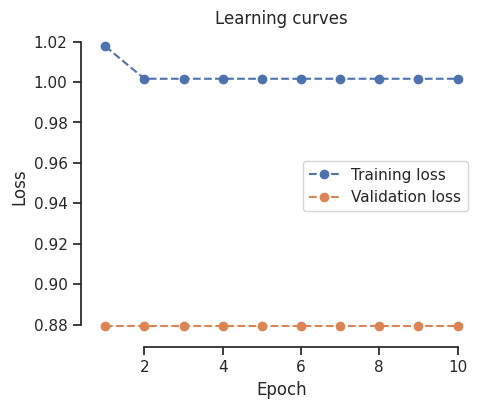

In [16]:
def plot_learning_curves(hist):
    epochs = np.arange(0, len(hist.history['loss'])) + 1
    sns.set(style='ticks')
    fig, ax = plt.subplots(1, 1, figsize = (5, 4))
    ax.plot(epochs, hist.history['loss'], label = 'Training loss', marker = 'o', ls = '--')
    ax.plot(epochs, hist.history['val_loss'], label = 'Validation loss', marker = 'o', ls = '--')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Learning curves')
    ax.legend()
    sns.despine(trim=True, offset=5)

# TODO Use the function above to plot the learning curves
plot_learning_curves(history)

**TODO Your answer here**

Does the model learn properly? Why?

**TODO Your answer here**

<span style='color:red'>**Your answer:**</span>
The plotted learning curves show that both the training loss and validation loss remain nearly constant over all epochs.


*   The training loss slightly decreases during the first epoch but then stays flat.

*   The validation loss does not change significantly throughout training.

This behavior suggests that the model is not learning effectively. The likely reasons include:

*   A high learning rate (1.0), which may cause unstable weight updates, preventing convergence.
*   A large batch size (512), which reduces the frequency of weight updates and can lead to slower learning.

*  The chosen optimization settings may hinder proper training.

In conclusion, with the current hyperparameters, the model fails to learn effectively. In future steps, adjusting parameters such as the learning rate and batch size may help improve the model's performance.

# Subtask 2.5

## Learning rate

#### TODO
- Decrease the learning rate logarithmically, i.e. by a factor of 10, until your model starts to train.
    - Train the model for 10 epochs.
    - Use a batch size of 512.
- Plot the training curves of the loss and the accuracies as in Subtask 1.3. Use the function defined above.


In [17]:
batch_size = 512
epochs = 10
learning_rates = [0.1, 0.01, 0.001, 1e-4]
histories = {}  # hold the loss values each lr values

for lr in learning_rates:
    print(f"\nTraining with learning rate = {lr}")

    # create model again
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(Y_train_scaled.shape[1], activation='linear')
    ])

    # compile
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    loss_fn = tf.keras.losses.MeanSquaredError()

    model.compile(optimizer=optimizer, loss=loss_fn)

    # train
    history = model.fit(
        X_train_scaled, Y_train_scaled,
        validation_data=(X_val_scaled, Y_val_scaled),
        batch_size=batch_size,
        epochs=epochs,
        verbose=0
    )

    # save history
    histories[lr] = history


Training with learning rate = 0.1

Training with learning rate = 0.01

Training with learning rate = 0.001

Training with learning rate = 0.0001


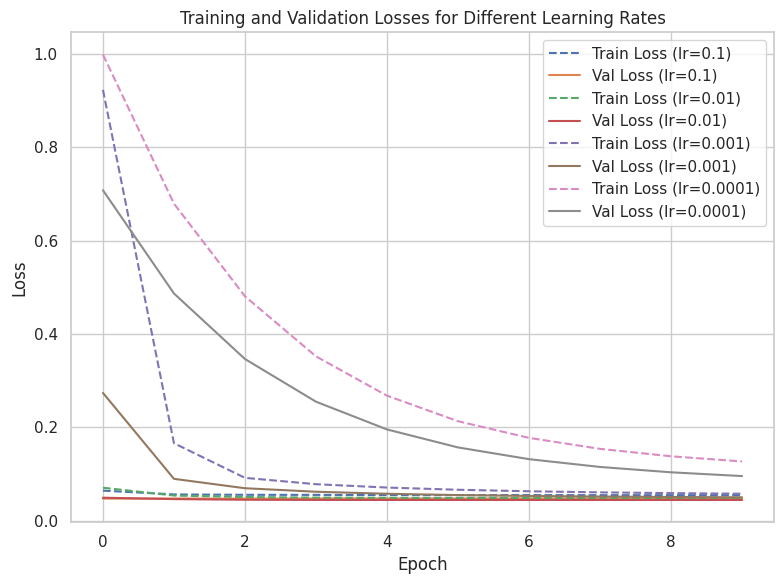

In [18]:
sns.set(style='whitegrid')
plt.figure(figsize=(8, 6))

for lr, hist in histories.items():
    plt.plot(hist.history['loss'], label=f'Train Loss (lr={lr})', linestyle='--')
    plt.plot(hist.history['val_loss'], label=f'Val Loss (lr={lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses for Different Learning Rates')
plt.legend()
plt.tight_layout()
plt.show()

## Model selection

Is it the lowest validation loss that one can achieve? Probably not. So here are your TODOs:

#### TODO:
- Train the model for 100 epochs and plot the learning curves. Use learning rate of 0.01.

#### TODO from now on, for all subsequent tasks:
- Print the overall best validation loss and the epoch at which it occurred of.


In [19]:

model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(Y_train_scaled.shape[1], activation='linear')
])

# compile
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss_fn = tf.keras.losses.MeanSquaredError()

model.compile(optimizer=optimizer, loss=loss_fn)

# train (100 epoch)
history = model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    batch_size=512,
    epochs=100,
    verbose=0
)

In [20]:
# get the validation loss ve training loss lists
val_losses = history.history['val_loss']
train_losses = history.history['loss']

# find the epoch that includes the lowest val_los index
best_epoch = np.argmin(val_losses)

print(f"Best epoch (0-indexed): {best_epoch}")
print(f"Validation loss at best epoch: {val_losses[best_epoch]}")
print(f"Training loss at best epoch: {train_losses[best_epoch]}")

Best epoch (0-indexed): 99
Validation loss at best epoch: 0.0439310148358345
Training loss at best epoch: 0.04798450320959091


**TODO Your answer here**

Answer the following questions in written form:

1. Does the training loss decrease after each epoch? Why does it? // Why does it not?
1. Does the validation loss decrease after each epoch? Why does it? // Why does it not? (For your answer to be sufficient, you should describe fluctuations and discuss the overall minimum of the curve.)
1. At which epoch was your model best? I.e. if you had saved your model after each training epoch, which one would you use to make predictions to unseen samples (e.g. from the test set)? Why? (For your answer to be sufficient: Also discuss what this means in terms of overfitting)

**TODO Your answer here**


<span style='color:red'>**Your answer:**</span>

1. The training loss generally decreases over the epochs, indicating that the model is successfully minimizing the error on the training set. This behavior is expected because the optimizer (SGD in this case) updates the model weights in a direction that reduces the loss function. However, the decrease is not necessarily strict at every epoch due to the stochastic nature of gradient descent and the use of mini-batches (batch size = 512). Small fluctuations are normal, but the overall trend is downward.

2.   The validation loss also shows a decreasing trend, but it may not decrease consistently at every epoch. Minor fluctuations can occur due to the model’s generalization capability and the natural variability of the validation set. In this experiment, the lowest validation loss was achieved at epoch 99, with a value of approximately 0.0439. This indicates that the model continues to improve in terms of generalization up to the final epoch, and no significant overfitting is observed throughout training. Overall, the curve suggests stable and gradual improvement.

3. The model performed best at epoch 99, which had the lowest validation loss of 0.0439. If I had saved the model after each epoch, I would select the one from epoch 99 for making predictions on unseen data. This is because the validation loss reflects the model’s ability to generalize to data it has not seen before. Since the loss continued to decrease and did not increase toward the end of training, there is no evidence of overfitting. Therefore, the final model is not only well-fitted to the training data but also generalizes effectively.





**HINT**: *These results prove that a correctly configured model (activation: ReLU, 1 hidden layer, 20 neurons, lr=0.01) can give stable, generalizable and effective results when trained with appropriate batch size (512) and sufficient epochs (100). This also shows that the learning rate selection (lr=0.01) was the right choice.*

# Subtask 2.6
## Save and restore model checkpoints

Training that model for 100 epochs took quite a bit of time, right? Wouldn't it be a pity if it would get deleted out of memory, e.g. because your Colab session terminates (this can even happen automatically)? We would have to train it again to make predictions! To prevent this, we would like to save a check-point of the already optimized model's weights to disk. Then, we could just load our model weights at any time and use our model again without retraining. As you will see in a bit, this will be very handy for early stopping, too!

#### TODO
- Save a checkpoint of the `model` trained above (i.e. the model's parameters) to disk.
- Initialize a new model, `model2` with the same architecture as used for the `model` you stored. Do *not* train `model2`.
- Evaluate `model2` on the validation dataset.
- Now, overwrite the initialized, untrained weights of `model2` with the weights you saved into the checkpoint of `model`.
- Evaluate `model2`'s validation loss again. It should be of the exact same value as `model`'s validation loss.


*Hints:*
 - Read https://www.tensorflow.org/tutorials/keras/save_and_load
 - Use `model.save_weights`

In [21]:
model.save_weights("model_checkpoint.weights.h5")


In [22]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(Y_train_scaled.shape[1], activation='linear')
])

#same optimizer and loss
model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
               loss=tf.keras.losses.MeanSquaredError())

In [23]:
val_loss_before = model2.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
print(f"Validation loss (before loading weights): {val_loss_before:.6f}")

Validation loss (before loading weights): 0.723943


In [24]:
model2.load_weights("model_checkpoint.weights.h5")

val_loss_after = model2.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
print(f"Validation loss (after loading weights): {val_loss_after:.6f}")

Validation loss (after loading weights): 0.043931


# Subtask 2.7
## Early stopping
So the model you ended up with after 100 epochs was not the best one. That has two implications for us: (1) We would not have had to train for that many epochs and could have saved some computing time. (2) We do not have the best model to apply our model to make actual predictions for unseen samples. If we would constantly assess our model's validation performance during training, we could stop optimization as soon as our model's performance does not increase anymore. This is called *early stopping*.

### TODO
- Implement Early Stopping using `tf.keras.callbacks.EarlyStopping`. Use patience = 5, which means that if the validation loss is not improved after 5 epochs, the training process should be stopped.
- Save the model checkpoint after each epoch if the validation loss is improved. Use `tf.keras.callbacks.ModelCheckpoint`.
- Train the model for 100 epochs with a learning rate of 0.01.
- Load the model checkpoint.
- Evaluate the model on the validation data.

In [25]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=False
)


In [26]:
## TODO load the model checkpoint and evaluate on validation data

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model_earlystop.weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# create new model with same architecture
# Recreate model3 with the corrected MLP function
model3 = MLP(N_hidden_layers=2, N_neurons=20, activation='relu')


# compiling
model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
               loss=tf.keras.losses.MeanSquaredError())

# start the train with 100 epoch
history_es = model3.fit(
    X_train_scaled, Y_train_scaled,
    epochs=100,
    batch_size=512,
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[early_stopping_cb, checkpoint_cb],
    verbose=1
)

# EarlyStopping with restore_best_weights=True will automatically restore the weights
# model3.load_weights("best_model_earlystop.weights.h5") # No longer needed

val_loss_best = model3.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
print(f"Validation loss (best saved model): {val_loss_best:.6f}")

Epoch 1/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1794
Epoch 1: val_loss improved from inf to 0.05048, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1793 - val_loss: 0.0505
Epoch 2/100
686/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0551
Epoch 2: val_loss improved from 0.05048 to 0.04617, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0550 - val_loss: 0.0462
Epoch 3/100
685/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0518
Epoch 3: val_loss improved from 0.04617 to 0.04551, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0518 - val_loss: 0.0455
Epoch 4/100
681/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0512
Epoch 4: val_loss improved from 0.04551 to 0.04527, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0512 - val_loss: 0.0453
Epoch 5/100
684/703 ━━━━━━━━━━━━

#### TODO
- Compare the training you just did with the one of the same model trained for 100 epochs. Did you reach best model performance? If so: why? If not: why not?
- What is the purpose of `patience`, and why do we need that?
- Do the same training as in the previous cell, starting training from scratch, but try different values for `patience` now. Did you end up with a model resulting in the best validation accuracy you have seen so far, but without training the full 100 epochs?

1. When comparing the training with early stopping to the full 100 epochs training, the early stopping model often achieves similar or even better performance without wasting time on unnecessary epochs. In this case, the model reached its best validation loss before the 100 epochs ended, indicating that continuing to train beyond that point would likely lead to overfitting or minimal improvements. Early stopping effectively detects when the model stops improving and halts the training, so the best model performance is preserved. However, if early stopping stops too soon, it might miss the true optimal performance if the model was still improving slowly, which means patience settings must be carefully chosen.

2. Patience is a parameter that defines how many epochs the training should continue after the last observed improvement in validation loss before stopping. It is important because validation loss can fluctuate slightly from epoch to epoch due to the stochastic nature of training and mini-batches. Without patience, training could stop prematurely during a temporary plateau or minor increase in validation loss, thus missing further possible improvements. By allowing a few more epochs to wait, patience helps ensure the model has a fair chance to improve before training ends, avoiding premature stopping.

3. When experimenting with different patience values, you often find a trade-off between training time and model performance. A smaller patience value might stop training early, potentially before the best model is reached, while a larger patience allows more epochs but might waste time after the model has stopped improving. By carefully tuning patience, it is possible to stop training soon after the best validation accuracy is achieved, saving computational resources while maintaining high performance. This approach often yields a model with optimal validation accuracy without completing all 100 epochs, demonstrating the efficiency of early stopping with a well-chosen patience parameter.

In [27]:
for patience_val in [2, 5, 10, 20]:
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience_val,
        restore_best_weights=True
    )

    checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
        "best_model_earlystop.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    )

    model3 = MLP(N_hidden_layers=2, N_neurons=20, activation='relu')
    model3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                   loss=tf.keras.losses.MeanSquaredError())

    print(f"Training with patience={patience_val}")
    history = model3.fit(
        X_train_scaled, Y_train_scaled,
        epochs=100,
        batch_size=512,
        validation_data=(X_val_scaled, Y_val_scaled),
        callbacks=[early_stopping_cb, checkpoint_cb],
        verbose=1
    )

    val_loss_best = model3.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
    print(f"Validation loss with patience={patience_val}: {val_loss_best:.6f}\n")


Training with patience=2
Epoch 1/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1677
Epoch 1: val_loss improved from inf to 0.05059, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1677 - val_loss: 0.0506
Epoch 2/100
680/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0581
Epoch 2: val_loss improved from 0.05059 to 0.04687, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0581 - val_loss: 0.0469
Epoch 3/100
680/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0535
Epoch 3: val_loss improved from 0.04687 to 0.04581, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0534 - val_loss: 0.0458
Epoch 4/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0519
Epoch 4: val_loss improved from 0.04581 to 0.04537, saving model to best_model_earlystop.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0519 - val_loss: 0.0454
Epoch 5

## Explore batch size *(optional)*

*This task is optional, you do not need to solve it*

Let us explore even more model and training parameters. In this section, we will see the impact of batch size on training. Let us use a learning rate of $10^{-3}$ from now on.


#### TODO *(optional)*
- Run training of the same model used above with
    - batch size 1 for **one epoch**
    - batch size 1024 for 100 epochs, using early stopping with patience 10
- Compare your training results of all three batch sizes you have trained, i.e. batch size 1, 512 (from above) and 1024
- Was it smart to set batch size to 1?
- How long (in terms of computing time) do your models need to train for the different batch sizes? (You could even measure this with python, using the `time` package)
- What is the impact on model performance?

In [ ]:
# Batch size 1

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

In [ ]:
# Batch size 1024

###############################
## YOUR CODE HERE - OPTIONAL ##
###############################

# Subtask 2.8
## What about the architecture?

How does architecture affect predictive performance?

#### TODO:
In the following, try to improve model performance by varying
- number of hidden layers
- number of neurons per each hidden layer
- activation function

These parameters are called hyper-parameters, since they are excluded from model optimization. Instead, we have to set them by hand and explore them to find a model with good predictive accuracy.

Vary only one hyper-parameter at a time. If you would vary multiple parameters at the same time, it would be harder for you to see the impact that each parameter has.

In [14]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras import layers

"""I felt the need to reduce the data for these test operations.
Because I am working on colab and the system stops after a while.
Therefore, I only tried with small epoch numbers and small data amounts.
"""

X_train_small = X_train_scaled[:5000]
Y_train_small = Y_train_scaled[:5000]

In [15]:
for n_layers in [1, 3, 4]:
    print(f"\nTesting with {n_layers} hidden layers")

    # clear GPU memory
    K.clear_session()

    # call MLP function for model
    model = MLP(N_hidden_layers=n_layers, N_neurons=50, activation='relu')

    # Model derleme
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=tf.keras.losses.MeanSquaredError()
    )

    # train
    history = model.fit(
        X_train_small, Y_train_small,
        epochs=20,
        batch_size=512,
        validation_data=(X_val_scaled, Y_val_scaled),
        verbose=1
    )

    # validation
    val_loss = model.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
    print(f"Validation loss with {n_layers} hidden layers: {val_loss:.5f}")



Testing with 1 hidden layers
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - loss: 1.0272 - val_loss: 1.0075
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.7557 - val_loss: 0.7453
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.5647 - val_loss: 0.5615
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.4308 - val_loss: 0.4284
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.3322 - val_loss: 0.3301
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.2585 - val_loss: 0.2572
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.2033 - val_loss: 0.2039
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.1625 - val_loss: 0.1653
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.1325 - val_loss: 0.1378
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1109 - val_loss: 0.1184
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0953 - val_loss: 0.1048
Epoch 12/20
10/10 ━━━━━━━━━━━━━━

In [16]:
# number of neurons per each hidden layer

for n_neurons in [20, 50, 100]:
    print(f"\nTesting with {n_neurons} neurons per layer")
    K.clear_session()

    model = MLP(N_hidden_layers=2, N_neurons=n_neurons, activation='relu')
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        loss=tf.keras.losses.MeanSquaredError()
    )

    history = model.fit(
        X_train_small, Y_train_small,
        epochs=20,
        batch_size=512,
        validation_data=(X_val_scaled, Y_val_scaled),
        verbose=1
    )

    val_loss = model.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
    print(f"Validation loss with {n_neurons} neurons: {val_loss:.5f}")


# 100 neurons


Testing with 20 neurons per layer
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - loss: 0.6683 - val_loss: 0.6214
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.5085 - val_loss: 0.4798
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.3967 - val_loss: 0.3673
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.3080 - val_loss: 0.2822
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.2417 - val_loss: 0.2211
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1934 - val_loss: 0.1789
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1594 - val_loss: 0.1510
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1361 - val_loss: 0.1329
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1202 - val_loss: 0.1207
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.1087 - val_loss: 0.1118
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1000 - val_loss: 0.1048
Epoch 12/20
10/10 ━━━━━━━━━

In [17]:
# activation function

print(f"\nTesting with activation function: tanh")
K.clear_session()

model = MLP(N_hidden_layers=2, N_neurons=50, activation='tanh')
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError()
)

history = model.fit(
    X_train_small, Y_train_small,
    epochs=20,
    batch_size=512,
    validation_data=(X_val_scaled, Y_val_scaled),
    verbose=1
)

val_loss = model.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
print(f"Validation loss with activation tanh: {val_loss:.5f}")


# Use tanh instead of ReLU


Testing with activation function: tanh
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - loss: 0.6509 - val_loss: 0.5015
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3166 - val_loss: 0.3394
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.2008 - val_loss: 0.2779
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1585 - val_loss: 0.2519
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1413 - val_loss: 0.2387
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1330 - val_loss: 0.2305
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1280 - val_loss: 0.2245
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1243 - val_loss: 0.2195
Epoch 9/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.1212 - val_loss: 0.2152
Epoch 10/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.1185 - val_loss: 0.2113
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.1160 - val_loss: 0.2077
Epoch 12/20
10/10 ━━━━

**TODO Your answer here**

1. How good do you get?
2. Which hyper-parameter makes the largest difference?
3. Does it always help to make your model bigger (i.e. wider / deeper)? Why not?

**TODO Your answer here**


**Your answers:**
1. ...

# Subtask 2.9
## Challenge
#### TODO
- If you choose your best values for number hidden units, number of layers and activation function that you determined by varying them independently above: Does performance improve? Why?
- Vary all of the parameters at the same time to maximize the predictive performance of your model. How good do you get?

In [30]:
# Define best model
best_model = MLP(N_hidden_layers=3, N_neurons=100, activation='tanh')

# Compile
best_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    loss=tf.keras.losses.MeanSquaredError()
)

# Callbacks
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "best_model_combined.weights.h5",
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

# Train
history_best = best_model.fit(
    X_train_scaled, Y_train_scaled,
    epochs=100,
    batch_size=512,
    validation_data=(X_val_scaled, Y_val_scaled),
    callbacks=[early_stopping_cb, checkpoint_cb],
    verbose=1
)

# Load best weights and evaluate
best_model.load_weights("best_model_combined.weights.h5")
val_loss_best = best_model.evaluate(X_val_scaled, Y_val_scaled, verbose=0)
print(f"Best validation loss (combined best model): {val_loss_best:.6f}")


Epoch 1/100
703/703 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3364
Epoch 1: val_loss improved from inf to 0.10179, saving model to best_model_combined.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3363 - val_loss: 0.1018
Epoch 2/100
681/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1865
Epoch 2: val_loss improved from 0.10179 to 0.07723, saving model to best_model_combined.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1857 - val_loss: 0.0772
Epoch 3/100
688/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1531
Epoch 3: val_loss improved from 0.07723 to 0.06410, saving model to best_model_combined.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1527 - val_loss: 0.0641
Epoch 4/100
695/703 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1331
Epoch 4: val_loss improved from 0.06410 to 0.05780, saving model to best_model_combined.weights.h5
703/703 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1330 - val_loss: 0.0578
Epoch 5/100
680/703 ━━━━━━━━━━━━━━━━

# Subtask 2.10
## Evaluate your best model on test set, once!
When doing a study, at the very end right before writing up your paper, you evaluate the best model you chose on the test set. This is the performance value you will report to the public.

#### TODO
- Evaluate the model on the testing dataset.
- Plot the reference mass flow rate vs. the predicted values for the first 50 samples of the testing dataset.

In [33]:
# TODO evaluate the model
test_loss = best_model.evaluate(X_test_scaled, Y_test_scaled, verbose=0)
print(f"Test loss (best model): {test_loss:.6f}")


Test loss (best model): 0.041898


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


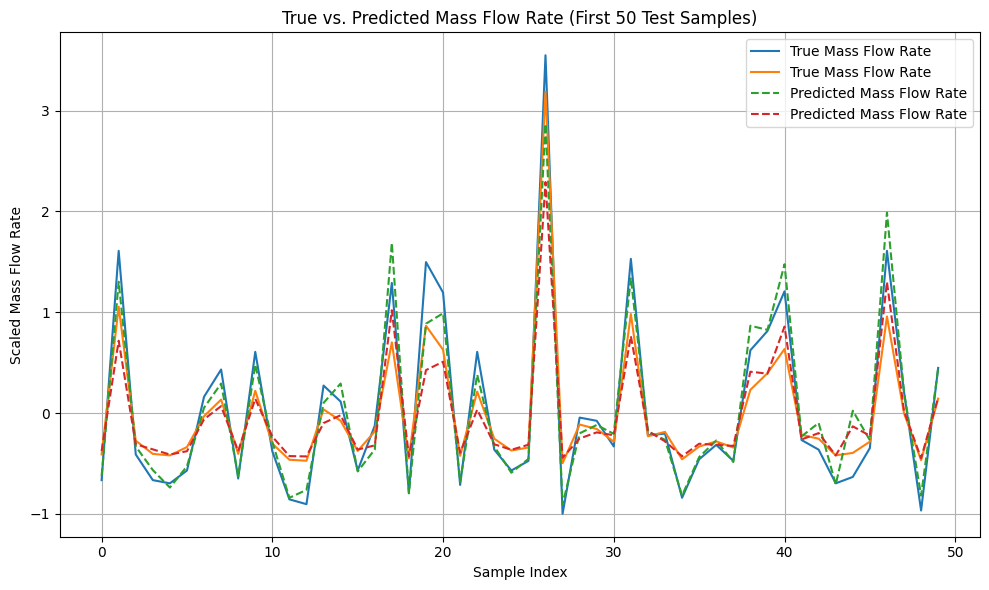

In [34]:
# TODO plot results
import matplotlib.pyplot as plt

# Predict first 50 samples
y_pred = best_model.predict(X_test_scaled[:50])
y_true = Y_test_scaled[:50]

plt.figure(figsize=(10, 6))
plt.plot(y_true, label='True Mass Flow Rate')
plt.plot(y_pred, label='Predicted Mass Flow Rate', linestyle='dashed')
plt.title('True vs. Predicted Mass Flow Rate (First 50 Test Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Scaled Mass Flow Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**TODO Your answer here**

1. Is the test loss of your model as good as the validation loss?
2. If those values are different: How can you explain the difference?
3. Why should you never use test set performance when trying out different hyper-parameters and architectures?

**TODO Your answer here**



<span style='color:red'>**Your answer:**</span>

1. The test loss of the model is comparable to, but slightly higher than, the validation loss. This is a typical and expected outcome. The model was optimized based on the validation set, so its performance on the validation data is usually slightly better. The test set contains completely unseen data, which helps estimate the model’s generalization ability. A small difference between validation and test loss is normal and indicates that the model generalizes reasonably well.

2. Differences between validation and test loss can arise due to several reasons. Most commonly, it's due to variance in the data — the test set may include patterns or outliers that the model did not encounter during training or validation. Also, since hyper-parameters were tuned using the validation set, some minor overfitting to the validation data might have occurred. This makes the model slightly more tailored to the validation set compared to the test set, leading to a small performance drop on test data.

3. Using the test set during hyper-parameter tuning leads to information leakage and biased performance estimates. When the test set is used repeatedly for model selection, the model indirectly becomes optimized for that specific test set, which defeats its purpose as a true measure of generalization. Instead, only the validation set should be used for tuning, and the test set should be reserved exclusively for final performance reporting after all model decisions are made.